In [1]:
#%pip install astropy

In [2]:
""" plot_s2_comparison.py
    
    Code to read in a Senintel-2 image, grab the ATL07/10 data and overaly/plot/analyze.
    Initial code written by Marco Bagnardi. Adapted by Alek Petty
  
    Output: 
      figures/release/profiles/S-2_overlay... - the main S-2/ICESat-2 overlay
      figures/release/profiles/s2-extra/croppedimage...: image rotated and cropped to be used by the profile overlay figure above
      figures/release/profiles/s2-extra/diagnostic...: looking at quality flag, adjusted freeboard and other metrics)
      figures/release/profiles/s2-extra/diagnostic_boxplot...: looking at number of height segmetns not included)
      figures/release/profiles/s2-extra/overlay...: the complete S-2 image with IS-2 overlay
      figures/release/profiles/s2-extra/AOI...: Area of Interest S-2 images

    example: 
      run as: python plot_s2_comparison.py -b 'gt1l' -e 'P5'

    Python dependencies:
        See below for the relevant module imports. More information on installation is given in the README file.

    Update history:
        08/30/2021: Version 1.
"""


### Import necessary Python modules
#import cartopy.crs as ccrs
#import cv2
try:
  from osgeo import gdal
  from osgeo import ogr
except:
  import gdal
  import ogr
import h5py
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
#from pyproj import Proj, transform
from pyproj import Proj, Transformer
from osgeo import gdal, osr
from scipy import ndimage, misc
import sys
from glob import glob
import os
from matplotlib.ticker import MaxNLocator
import numpy.ma as ma
import argparse
import rasterio
import cartopy.crs as ccrs
from scipy.interpolate import NearestNDInterpolator
import earthaccess

# Our own module of bespoke functions
import utils as ut

In [3]:
#auth = earthaccess.login(persist=True)

In [4]:
def get_cloud_granule(granule_name_str):
    
    # ICESat-2/earthaccess stuff
    #auth = earthaccess.login()

    granules_cloud = earthaccess.search_data(
        short_name = granule_name_str[0:5],
        #version = '006',
        cloud_hosted = True,
        bounding_box = (-180,-90,180,90),
        #temporal = ('2020-10-01','2020-10-30'),
        granule_name=granule_name_str,
    )

    # Open files (not found a way of not needing to do this..)
    atl07_fileT = earthaccess.open(granules_cloud)[-1]
    #ATL = h5py.File(atl07_file[-1], 'r')
    return atl07_fileT

In [5]:
def pick_profile(example):
    """ Pick S-2/ICESat-2 profiles to analyze"""
    
    if example=='P1':
    
        date='20190317_SH'
        
        version='*'
        # Sentinel-2 surface reflectance single-band geoTIFF file
        imageFile = s2_data_path+'/RT_T20CPE_20190317T122209_B04.tif'
        
        # ATLAS DATA
        atl07_granule_name_str='ATL07-02_20190317*_12070201_*'+relStr[-3:]+'_'+version+'.h5'
        atl10_granule_name_str='ATL10-02_20190317*_12070201_*'+relStr[-3:]+'_'+version+'.h5'
        
        try:
            ATL07_dataFile = glob(data_path+relStr+'/ATL07/'+atl07_granule_name_str)[0]
            ATL10_dataFile = glob(data_path+relStr+'/ATL10/'+atl10_granule_name_str)[0]
        except:
            print('No local data, try the cloud...')
            ATL07_dataFile = get_cloud_granule(atl07_granule_name_str)
            ATL10_dataFile = get_cloud_granule(atl10_granule_name_str)
            print(ATL07_dataFile, ATL10_dataFile)
        
        # Latitudinal limits
        #Slim = -75
        #Nlim = -70.57
        Slim = -73
        Nlim = -72.57
        
        print('Arctic profile:', example, date, str(Slim)+'-'+str(Nlim))
        
        bufferRatio=60 # Bigger number smaler width (try 100 for zoom in)
    
    elif (example=='P2')|(example=='P3')|(example=='P4'):
      
        date='20190526_NH'
        
        version='*'
        
        # Sentinel-2 surface reflectance single-band geoTIFF file
        imageFile = s2_data_path+'/RT_T14XMQ_20190525T230121_B04.tif'
        
        
        # ATLAS DATA
        # -1 indicates we're using the latest version of the data (i.e. the higher number)
        #ATL07_dataFile = glob(data_path+relStr+'/ATL07/ATL07-01_20190526*_08820301_'+relStr[-3:]+'_'+version+'.h5')[-1]
        #ATL10_dataFile = glob(data_path+relStr+'/ATL10/ATL10-01_20190526*_08820301_'+relStr[-3:]+'_'+version+'.h5')[-1]
        # ATLAS DATA
        atl07_granule_name_str='ATL07-01_20190526*_08820301_*'+relStr[-3:]+'_'+version+'.h5'
        atl10_granule_name_str='ATL10-01_20190526*_08820301_*'+relStr[-3:]+'_'+version+'.h5'
        
        try:
            ATL07_dataFile = glob(data_path+relStr+'/ATL07/'+atl07_granule_name_str)[0]
            ATL10_dataFile = glob(data_path+relStr+'/ATL10/'+atl10_granule_name_str)[0]
        except:
            print('No local data, try the cloud...')
            ATL07_dataFile = get_cloud_granule(atl07_granule_name_str)
            ATL10_dataFile = get_cloud_granule(atl10_granule_name_str)
        
        
        if example=='P2':
            Slim = 80.57
            Nlim = 81
            #Slim = 78
            #Nlim = 88
        
        if example=='P3':
            Slim = 80.15
            Nlim = 80.57
        
        if example=='P4':
            # focussing on the big lead in gt21 (need to also manually change the size of the top line when doing so!)
            Slim = 80.6
            Nlim = 80.66
        
    print('Arctic profile:', example, date, str(Slim)+'-'+str(Nlim))
    
    bufferRatio=60 # Bigger number = smaler width (try 100 for zoom in)
    
    ### Check if ICESat-2 ATLAS file is valid
    try:
        ATL07file = h5py.File(ATL07_dataFile, 'r')
    except:
        sys.exit('not a valid file')
    
    ### Check if ICESat-2 ATLAS file is valid
    try:
        ATL10file = h5py.File(ATL10_dataFile, 'r')
    except IOError:
        sys.exit('not a valid file')
    
    return imageFile, ATL07file, ATL10file, Slim, Nlim, bufferRatio, date

In [6]:
def get_geoTIFF_info(geoTIFF, plot=False):
    try:
        geoTIFF = gdal.Open(imageFile)
    except IOError:
        sys.exit('geoTIFF file is not a valid file')
    # Image size
    geoTIFF_size_x = geoTIFF.RasterXSize # Size of x
    geoTIFF_size_y = geoTIFF.RasterYSize # Size of y
    
    # Geographic information (geocoded extent, projection, etc.)
    # UL corner x-coordinate, W-E pixel size, rotation (0 if N up),UL corner y-coordinate, rotation (0 if N up), N-S pixel size
    geoTIFF_geo_trans = geoTIFF.GetGeoTransform()   
                                                  
    geoTIFF_proj = geoTIFF.GetProjection() # Geographic projection information
    print(geoTIFF_proj)
    
    geoTIFF_inproj = osr.SpatialReference()
    geoTIFF_inproj.ImportFromWkt(geoTIFF_proj)
    
    # Convert WKT projection information to a CartoPy projection
    geoTIFF_projcp = geoTIFF_inproj.GetAuthorityCode('PROJCS')
    geoTIFF_projection = ccrs.epsg(geoTIFF_projcp)
    
    # Extract edge coordinates using half resolution cell to get coordinates of pixel center
    geoTIFF_x_min = geoTIFF_geo_trans[0] + geoTIFF_geo_trans[1]*0.5
    geoTIFF_x_max = geoTIFF_geo_trans[0] + geoTIFF_size_x*geoTIFF_geo_trans[1] - geoTIFF_geo_trans[1]*0.5
    
    geoTIFF_y_min = geoTIFF_geo_trans[3] + geoTIFF_size_y*geoTIFF_geo_trans[5] + geoTIFF_geo_trans[5]*0.5

    # changed to minus!! maybe it now returns this as a vector height not scaler I guess..
    geoTIFF_y_max = geoTIFF_geo_trans[3] + geoTIFF_geo_trans[5]*0.5
    
    geoTIFF_extent = [geoTIFF_x_min, geoTIFF_x_max, geoTIFF_y_min, geoTIFF_y_max]

    
    
    # Print basic GEOTIFF information
    print('Image size: ', geoTIFF_size_x, geoTIFF_size_x)
    print('Image projection EPGS code: ', geoTIFF_projcp)
    print('Xmin: ', geoTIFF_extent[0])
    print('Xmax: ', geoTIFF_extent[1])
    print('Ymin: ', geoTIFF_extent[2])
    print('Ymax: ', geoTIFF_extent[3])
    
    # Convert geoTIFF image to data array
    surfReflectance = geoTIFF.ReadAsArray()
    
    out_proj = 'epsg:' + str(geoTIFF_projcp) # String with geoTIFF projection epsg code
    
    
    if surfReflectance.ndim>2:
        print('multi-band image so just take the 1st (red) band for now')
        surfReflectance=surfReflectance[0]
        band='Red'
    else:
        band='RGB'



    
    if plot==True:
        subplot_kw = dict(projection=geoTIFF_projection)
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot image as grayscale
        im = ax.imshow(surfReflectance, extent=geoTIFF_extent, origin='upper', cmap='gray')
        
        
    # Close dataset
    geoTIFF = None

    return surfReflectance, geoTIFF, geoTIFF_extent, out_proj, geoTIFF_geo_trans, band

def get_geoTIFF_info_rasterio(imageFile, plot=False):
#https://rasterio.readthedocs.io/en/latest/api/rasterio.crs.html
    #try:
    #  geoTIFF = rasterio.open(imageFile)
    #except IOError:
    #  sys.exit('geoTIFF file is not a valid file')
    
    # Convert geoTIFF image to data array
    #surfReflectance = geoTIFF.read()
    #try:
    with rasterio.open(imageFile, 'r') as ds:
        arrT = ds.read()  # read all raster values
    
    print(arrT.shape, arrT.shape[0])
    #except:
    #  sys.exit('geoTIFF file is not a valid file')
      
    if arrT.shape[0]>1:
        print('multi-band image so just take the 1st (red) band for now - WORK ON CONVERTING TO RGB INSTEAD!')
        arr=arrT[0]
        band='Red'
    else:
        print('Single band image')
        band='RGB'
        arr=arrT[0]

    print(arr.shape, arr.shape[0])
    # Get extent of image (results slightly different to GDAL)
    geoTIFF_extent = ds.bounds
    
    # Extract spatial metadata
    geoTIFF_proj = ds.crs
    geoTIFF_geo_trans  = ds.transform
    
    #out_proj = 'epsg:' + str(geoTIFF_proj) # String with geoTIFF projection epsg code
    
    # Print basic GEOTIFF information
    print('Image size: ', ds.width, ds.height)
    print('Image projection: ', geoTIFF_proj)
    print('Xmin: ', geoTIFF_extent[0])
    print('Xmax: ', geoTIFF_extent[1])
    print('Ymin: ', geoTIFF_extent[2])
    print('Ymax: ', geoTIFF_extent[3])
    print('geoTIFF_extent', geoTIFF_extent)
    
    print('geoTIFF_geo_trans', geoTIFF_geo_trans)
    
    if plot==True:
        subplot_kw = dict(projection=geoTIFF_proj)
        fig, ax = plt.subplots(figsize=(10, 10))
        
        # Plot image as grayscale
        im = ax.imshow(arr, extent=geoTIFF_extent, origin='upper', cmap='gray')
        plt.savefig(figPath+'s2-extra/image_test.png', dpi=300)
        
    # Close dataset
    geoTIFF = None
    
    return arr, ds, geoTIFF_extent, geoTIFF_proj, geoTIFF_geo_trans, band

def get_value_at_point(array_from, pos, geoTIFF_geo_trans):
    """ Extract raster value at given position from coordinates """
    try:
        samp_x = int((pos[0] - geoTIFF_geo_trans[0]) / geoTIFF_geo_trans[1])
        samp_y = int((pos[1] - geoTIFF_geo_trans[3]) / geoTIFF_geo_trans[4])
        return array_from[samp_y-1, samp_x-1]
    except:
        return np.nan
        #print('outside image extent', pos)
        


def createShapefile(filename, LL_x, LL_y, UL_x, UL_y, UR_x, UR_y, LR_x, LR_y):
    
    driver = ogr.GetDriverByName('ESRI Shapefile')

    datasource = driver.CreateDataSource(filename)
    layer = datasource.CreateLayer('layerName',geom_type=ogr.wkbPolygon)

    outline = ogr.Geometry(type=ogr.wkbLinearRing)
    outline.AddPoint(LL_x, LL_y)
    outline.AddPoint(UL_x, UL_y)
    outline.AddPoint(UR_x, UR_y)
    outline.AddPoint(LR_x, LR_y)
    outline.AddPoint(LL_x, LL_y)
    polygon = ogr.Geometry(type=ogr.wkbPolygon)
    polygon.AddGeometry(outline)

    #create feature object with polygon geometry type from layer object:
    feature = ogr.Feature( layer.GetLayerDefn() )
    feature.SetGeometry(polygon)
    layer.CreateFeature(feature)
   
    return

def rotate_IS2_S2(ATL07dF_crop_aoi, bufferRatio):
    # Trigonometry calculations
    a = ATL07dF_crop_aoi.UTM_Y.iloc[0] - ATL07dF_crop_aoi.UTM_Y.iloc[-1]
    b = ATL07dF_crop_aoi.UTM_X.iloc[0] - ATL07dF_crop_aoi.UTM_X.iloc[-1]
    c = np.sqrt((a**2) + (b**2))
    
    cosA = (b**2 + c**2 - a**2) / (2*b*c)
    inclin = np.arccos(cosA)
    inclin_deg = np.degrees(inclin)
    
    # Adjust size of buffer zone from ICESat-2 ground track depending on length of subset
    buffer = c/bufferRatio
    
    deltaX = buffer * np.sin(inclin)
    deltaY = buffer * np.cos(inclin)
    
    # Compute coordinates of corners of AOI
    
    # Descending satellite pass
    if ATL07dF_crop_aoi.UTM_Y.iloc[0] > ATL07dF_crop_aoi.UTM_Y.iloc[-1]:
        rev = True # set flag to determine how to apply rotation
        
        UL_x = ATL07dF_crop_aoi.UTM_X.iloc[0] - deltaX
        UL_y = ATL07dF_crop_aoi.UTM_Y.iloc[0] + deltaY
        
        UR_x = ATL07dF_crop_aoi.UTM_X.iloc[0] + deltaX
        UR_y = ATL07dF_crop_aoi.UTM_Y.iloc[0] - deltaY
        
        LL_x = ATL07dF_crop_aoi.UTM_X.iloc[-1] - deltaX
        LL_y = ATL07dF_crop_aoi.UTM_Y.iloc[-1] + deltaY
        
        LR_x = ATL07dF_crop_aoi.UTM_X.iloc[-1] + deltaX
        LR_y = ATL07dF_crop_aoi.UTM_Y.iloc[-1] - deltaY

    # Ascending satellite pass    
    if ATL07dF_crop_aoi.UTM_Y.iloc[0] < ATL07dF_crop_aoi.UTM_Y.iloc[-1]:
        rev = False # set flag to determine how to apply rotation
        
        UL_x = ATL07dF_crop_aoi.UTM_X.iloc[0] - deltaX
        UL_y = ATL07dF_crop_aoi.UTM_Y.iloc[0] - deltaY
        
        UR_x = ATL07dF_crop_aoi.UTM_X.iloc[0] + deltaX
        UR_y = ATL07dF_crop_aoi.UTM_Y.iloc[0] + deltaY
        
        LL_x = ATL07dF_crop_aoi.UTM_X.iloc[-1] - deltaX
        LL_y = ATL07dF_crop_aoi.UTM_Y.iloc[-1] - deltaY
        
        LR_x = ATL07dF_crop_aoi.UTM_X.iloc[-1] + deltaX
        LR_y = ATL07dF_crop_aoi.UTM_Y.iloc[-1] + deltaY

    # Print AOI information
    print('ICESat-2 inclination angle in imagery coordinate system: ', inclin_deg)
    print('AOI coordinates:')
    print('UL: ', UL_x, UL_y)
    print('UR: ', UR_x, UR_y)
    print('LR: ', LR_x, LR_y)
    print('LL: ', LL_x, LL_y)
    
    return rev, inclin_deg, UL_x, UL_y, UR_x, UR_y, LR_x, LR_y, LL_x, LL_y, buffer

def print_df_size(ATL07dF_crop_aoi, ATL10dF_crop_aoi, ATL07dF_crop, ATL10dF_crop):
    print('AOI n. of columns: ', ATL10dF_crop_aoi.shape[1], " * added surface refelctance value.")
    print('AOI n. of points: ', ATL10dF_crop_aoi.shape[0])

    print('start lat/lon of subset', ATL07dF_crop_aoi['lats'].iloc[0], ATL07dF_crop_aoi['lons'].iloc[0])
    print('end lat/lon of subset', ATL07dF_crop_aoi['lats'].iloc[-1], ATL07dF_crop_aoi['lons'].iloc[-1])
    
    print('start lat/lon of ATL10 subset', ATL10dF_crop_aoi['lats'].iloc[0], ATL10dF_crop_aoi['lons'].iloc[0])
    print('end lat/lon of ATL10 subset', ATL10dF_crop_aoi['lats'].iloc[-1], ATL10dF_crop_aoi['lons'].iloc[-1])
    
    print('start lat/lon of profile across entire image', ATL07dF_crop['lats'].iloc[0], ATL07dF_crop['lons'].iloc[0])
    print('end lat/lon of profile across entire image', ATL07dF_crop['lats'].iloc[-1], ATL07dF_crop['lons'].iloc[-1])
    
    print('length of subset', str(int(ATL07dF_crop_aoi['along_dist'].iloc[-1] - ATL07dF_crop_aoi['along_dist'].iloc[0]))+' m')
    print('length of ATL10 subset', str(int(ATL10dF_crop_aoi['along_dist'].iloc[-1] - ATL10dF_crop_aoi['along_dist'].iloc[0]))+' m')
    print('length of profile across entire image', str(int(ATL07dF_crop['along_dist'].iloc[-1] - ATL07dF_crop['along_dist'].iloc[0]))+' m')


In [7]:
# Plotting functions

def plot_height_freeboard(ATL07dF_crop_aoi, ATL10dF_crop_aoi):

    # play around with adjusting the bounds on the freeboard data (removing leads etc)
    ATL10dF_crop_aoi_adj = ATL10dF_crop_aoi[(ATL10dF_crop_aoi['ssh_flag'] < 0.5) & (ATL10dF_crop_aoi['seg_type_flag']==1 ) & (ATL10dF_crop_aoi['freeboard']>0.04)]
    
    mean_fb_adj=np.round(np.mean(ATL10dF_crop_aoi_adj['freeboard']), decimals=3)
    
    shadingSize=30
    cmap_ssh = colors.ListedColormap(['red', 'yellow'])
    
    # Generate plot with white background
    #%matplotlib qt
    #%matplotlib inline
    fig= plt.figure(figsize=(10,8))
    #fig.patch.set_facecolor('xkcd:white')
    
    # ATL07 heights ssh label
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=1)
    
    for index, row in ATL07dF_crop_aoi.iterrows():
      #x0 = row['along_dist'] - row['seg_length']/2000
      x0 = row['along_dist'] - shadingSize/2000
      x1 = row['along_dist'] + shadingSize/2000
      
      if row['ssh_flag'] > 0.1:
          plt.axvspan(x0,x1, facecolor='k', alpha=0.2)
          
    plt.scatter(ATL07dF_crop_aoi['along_dist'], ATL07dF_crop_aoi['height'], c=ATL07dF_crop_aoi['height'], cmap='hot', s=2, zorder=2)
    plt.xlim(np.amin(ATL10dF_crop_aoi['along_dist']), np.amax(ATL10dF_crop_aoi['along_dist']))
    ax1.xaxis.set_ticklabels([])
    plt.ylim(-0.5, 3)
    ax1.annotate('Grey shading is ssh_flag',xy=(0.02, 0.87), xycoords='axes fraction')
    plt.ylabel('ATL07 Height')
    # ATL07 heights (in atl10)
    ax2 = plt.subplot2grid((5, 1), (1, 0), rowspan=1)
    
    for index, row in ATL07dF_crop_aoi.iterrows():
      x0 = row['along_dist'] - shadingSize/2000
      x1 = row['along_dist'] + shadingSize/2000
      
      if row['ssh_flag'] > 0.1:
          plt.axvspan(x0,x1, facecolor='k', alpha=0.2)
          
    plt.scatter(ATL07dF_crop_aoi['along_dist'], ATL07dF_crop_aoi['height'], c=atlmaskint, vmin=0, vmax=1, cmap='viridis_r', s=2, zorder=2)
    plt.xlim(np.amin(ATL10dF_crop_aoi['along_dist']), np.amax(ATL10dF_crop_aoi['along_dist']))
    plt.ylim(-0.5, 3)
    ax2.xaxis.set_ticklabels([])
    plt.ylabel('ATL07 Height')
    ax2.annotate('Purple markers not in ATL10',xy=(0.02, 0.87), xycoords='axes fraction')
    
    ax3 = plt.subplot2grid((5, 1), (2, 0), rowspan=1)
    #for x in range(np.size(x0)):
      #print(x)
    #for m in range(np.size(atlmask)):
    #    if atlmask[m]==False:
    #        plt.axvspan(x0[m],x1[m], facecolor='k', alpha=0.1)

    for index, row in ATL07dF_crop_aoi.iterrows():
      x0 = row['along_dist'] - shadingSize/2000
      x1 = row['along_dist'] + shadingSize/2000
      
      if row['ssh_flag'] > 0.1:
          plt.axvspan(x0,x1, facecolor='k', alpha=0.2)
    
    
    cmap = plt.cm.get_cmap('gnuplot', 7)    # 11 discrete colors
    
    imq=plt.scatter(ATL07dF_crop_aoi['along_dist'], ATL07dF_crop_aoi['height'], c=ATL07dF_crop_aoi['quality_flag'], cmap=cmap, vmin=-1.5, vmax=5.5, s=2, zorder=2)
    plt.xlim(np.amin(ATL10dF_crop_aoi['along_dist']), np.amax(ATL10dF_crop_aoi['along_dist']))
    plt.ylim(-0.5, 3)
    ax3.xaxis.set_ticklabels([])
    plt.ylabel('ATL07 Height')
    percent=np.round(np.size(np.where(ATL07dF_crop_aoi['quality_flag']>4))/np.size(ATL07dF_crop_aoi['quality_flag'])*100, decimals=2)
    
    ax3.annotate('Quality flag ('+str(percent)+'% > 4)',xy=(0.02, 0.87), xycoords='axes fraction')
    
    cax = fig.add_axes([0.925, 0.41, 0.022, 0.2])
    cbar = plt.colorbar(imq,cax=cax, orientation='vertical', extend='both', use_gridspec=True)
    #cbar.set_label('Quality flag', labelpad=28, rotation=0)
    xticks1 = np.linspace(-1, 5, 7)
    cbar.set_ticks(xticks1)
    cbar.set_ticklabels(['inv', '0', '1', '2', '3', '4', '5'])
    #plt.clim(-1.5,5.5)
    
    ax4 = plt.subplot2grid((5, 1), (3, 0), rowspan=1)
    #mask = np.isin(sub_DF['height_segment_id'].values, ATL10dF_crop_aoi['height_segment_id'].values,  invert=True)
    #for m in range(np.size(atlmask)):
    #    if atlmask[m]==False:
    #        plt.axvspan(x0[m],x1[m], facecolor='k', alpha=0.1)
    # Add lead_flag=1 shading
    for index, row in ATL10dF_crop_aoi.iterrows():
      # CHANGE TO LEAD LENGTH
      x0 = row['along_dist'] - shadingSize/2000
      x1 = row['along_dist'] + shadingSize/2000
      
      if row['ssh_flag'] > 0.1:
          plt.axvspan(x0,x1, facecolor='k', alpha=0.2)
    
    ax4.annotate('Grey shading is leads',xy=(0.02, 0.87), xycoords='axes fraction')
    plt.scatter(ATL10dF_crop_aoi['along_dist'], ATL10dF_crop_aoi['freeboard'], c=ATL10dF_crop_aoi['freeboard'], cmap='hot', s=2, zorder=2)
    #ax3.xaxis.set_ticklabels([])
    plt.ylabel('Freeboard')
    plt.xlabel('Along track distance (km)')
    plt.xlim(np.amin(ATL10dF_crop_aoi['along_dist']), np.amax(ATL10dF_crop_aoi['along_dist']))
    plt.ylim(-0.5, 3)
    ax4.annotate('Mean = '+str(mean_fb)+' m',xy=(0.8, 0.84), xycoords='axes fraction')
    
    ax5 = plt.subplot2grid((5, 1), (4, 0), rowspan=1)
    #mask = np.isin(sub_DF['height_segment_id'].values, ATL10dF_crop_aoi['height_segment_id'].values,  invert=True)
    #for m in range(np.size(atlmask)):
    #    if atlmask[m]==False:
    #        plt.axvspan(x0[m],x1[m], facecolor='k', alpha=0.1)
    # Add lead_flag=1 shading
    for index, row in ATL10dF_crop_aoi.iterrows():
      # CHANGE TO LEAD LENGTH
      x0 = row['along_dist'] - shadingSize/2000
      x1 = row['along_dist'] + shadingSize/2000
      
      if row['ssh_flag'] > 0.1:
          plt.axvspan(x0,x1, facecolor='k', alpha=0.2)
    
    ax5.annotate('Adjusted freeboard',xy=(0.02, 0.87), xycoords='axes fraction')
    plt.scatter(ATL10dF_crop_aoi_adj['along_dist'], ATL10dF_crop_aoi_adj['freeboard'], c=ATL10dF_crop_aoi_adj['freeboard'], cmap='hot', s=2, zorder=2)
    #ax3.xaxis.set_ticklabels([])
    plt.ylabel('Freeboard')
    plt.xlabel('Along track distance (km)')
    plt.xlim(np.amin(ATL10dF_crop_aoi['along_dist']), np.amax(ATL10dF_crop_aoi['along_dist']))
    plt.ylim(-0.5, 3)
    ax5.annotate('Mean = '+str(mean_fb_adj)+' m',xy=(0.8, 0.84), xycoords='axes fraction')
    
    
    plt.subplots_adjust(left=0.06, right=0.92, top=0.96, bottom=0.08, wspace=0, hspace=0)
    #plt.tight_layout()
    ### Save plot to file
    plt.savefig(figPath+'s2-extra/diagnostic_'+date+beam_name+relStr+str(Slim)+str(Nlim)+example+'.png', dpi=300)

def plot_diagnostic_boxplot(ATL07dF_crop_aoi):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (11, 4), sharex=False, sharey=True)
    plt.sca(ax1)
    fig.patch.set_facecolor('xkcd:white')
    plt.scatter(ATL07dF_crop_aoi['along_dist'].values[atlmask], ATL07dF_crop_aoi['height'].values[atlmask], color='r', s=2, alpha=0.3)
    #plt.scatter(ATL07dF_crop_aoi['along_dist'].values[~atlmask], ATL07dF_crop_aoi['elev'].values[~atlmask], color='b', s=2, alpha=0.3)
    plt.annotate('Segments not in ATL10', xy=(0.02, 0.92), xycoords='axes fraction')
    plt.xlabel('Along track distance (km)')
    plt.ylabel('Heights (m)')
    plt.sca(ax2)
    plt.boxplot([ATL07dF_crop_aoi['height'].values[~np.isnan(ATL07dF_crop_aoi['height'].values)], ATL07dF_crop_aoi['height'].values[~atlmask][~np.isnan(ATL07dF_crop_aoi['height'].values[~atlmask])], ATL07dF_crop_aoi['height'].values[atlmask][~np.isnan(ATL07dF_crop_aoi['height'].values[atlmask])]])
    ax2.set_xticklabels(['ATL07 Heights', 'In ATL10', 'Not in ATL10'])
    plt.savefig(figPath+'s2-extra/diagnostic_boxplot_'+date+beam_name+relStr+str(Slim)+str(Nlim)+example+'.png', dpi=300)


In [30]:



### 1. Data ingestion and preparation
################### Input data file names ########################################


data_path = '/home/jovyan/Data/IS2/'

s2_data_path = '/home/jovyan/Data/S2'

figPath='/home/jovyan/GitHub-output/ICESat-2-sea-ice-tools/plot_s2_comparison/'

if not os.path.exists(figPath):
  os.makedirs(figPath)
if not os.path.exists(figPath+'s2-extra/'):
  os.makedirs(figPath+'s2-extra/')
#if not os.path.exists(savePath):
#  os.makedirs(savePath)

relStr='rel006'
example = 'P2'
beam_name = 'gt2l'

print(relStr, example, beam_name)

band=0 #0 = red (in some cases set to np.nan if just single band)


rel006 P2 gt2l


In [31]:
################### Read command line input parameters ########################################

#inps = parse()
# Check for missing command line input parameters
#if inps.example is None:
#    print('Missing example profile index. Use option -e')

#    sys.exit(1)
#if inps.beam_name is None:
#    print('Missing beam. Use option -b')
#    sys.exit(1)



Read in S-2/ICESat-2 data...
No local data, try the cloud...
Granules found: 1
Opening 1 granules, approx size: 0.38 GB
using provider: NSIDC_CPRD


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Granules found: 1
Opening 1 granules, approx size: 0.21 GB
using provider: NSIDC_CPRD


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Arctic profile: P2 20190526_NH 80.57-81
/home/jovyan/Data/S2/RT_T14XMQ_20190525T230121_B04.tif
PROJCS["WGS 84 / UTM zone 14N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-99],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32614"]]
Image size:  10980 10980
Image projection EPGS code:  32614
Xmin:  399965.0
Xmax:  509755.0
Ymin:  8890195.0
Ymax:  8999995.0
orientation flag: 0
Backward orientation
[3.4028235e+38 3.4028235e+38 3.4028235e+38 ... 3.4028235e+38 3.4028235e+38
 3.4028235e+38]
seg limits: 3.5475187 9371.75
lon limits: -111.3

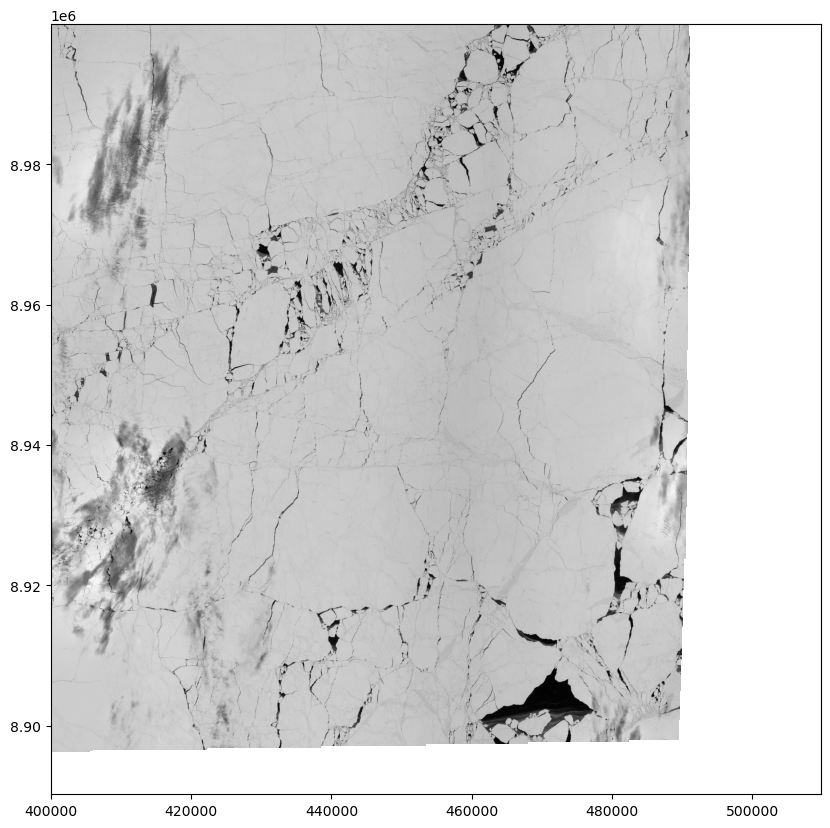

In [32]:
################### Read S-2/ICESat-2 data for given example profile ########################################
print('Read in S-2/ICESat-2 data...')
imageFile, ATL07_dataFile, ATL10_dataFile, Slim, Nlim, bufferRatio, date = pick_profile(example)
print(imageFile)
### Read geoTIFF file and print spatial extent information
surfReflectance, geoTIFF, geoTIFF_extent, out_proj, geoTIFF_geo_trans, band = get_geoTIFF_info(imageFile,plot=True)

### Read ATL07 file into pandas dataframe
ATL07dF, beamStr, beamStrength = ut.get_atl07_data_beam_extra(ATL07_dataFile, beamStr=beam_name, km_unit=True)

if int(relStr[-1])<6:
    ATL10dF, _ = ut.get_atl10_data_beam_extra(ATL10_dataFile, beamStr=beam_name, km_unit=True)
else:
    print('Release 006 or higher so use different data loader as names changed..')
    ATL10dF, _ = ut.get_atl10_freeboards_rel006(ATL10_dataFile, beam=beam_name, km_unit=True)
    
    
### Transform WGS84 Latitude and Longitude to UTM X and Y
# ATLAS data projection
ATL_inProj = Proj('epsg:4326') 
# GeotTIFF projection
ATL_outProj = Proj(out_proj) 

# Transform coordinates (old way)
#seg_x_utm, seg_y_utm = transform(ATL_inProj, ATL_outProj, ATL07dF['lons'].values, ATL07dF['lats'].values) 
#seg_x_utm10, seg_y_utm10 = transform(ATL_inProj, ATL_outProj, ATL10dF['lons'].values, ATL10dF['lats'].values) 

transformer = Transformer.from_crs(4326, out_proj, always_xy=True)
seg_x_utm, seg_y_utm = transformer.transform(ATL07dF['lons'].values, ATL07dF['lats'].values)
seg_x_utm10, seg_y_utm10 = transformer.transform(ATL10dF['lons'].values, ATL10dF['lats'].values)


# Add new coorinates to dataframe
ATL07dF['UTM_X'] = seg_x_utm
ATL07dF['UTM_Y'] = seg_y_utm

# Add new coorinates to dataframe
ATL10dF['UTM_X'] = seg_x_utm10
ATL10dF['UTM_Y'] = seg_y_utm10

# Replace no-data value 3.4028235e+38 with Numpy NaN in data frame
ATL07dF = ATL07dF.replace(np.max(ATL07dF.height), np.nan)
# Replace no-data value 3.4028235e+38 with Numpy NaN in data frame
#ATL10dF = ATL10dF.replace(np.max(ATL10dF.freeboard), np.nan)

# Crop ICESat-2 data frame to imagery extent
ATL07dF_crop = ATL07dF[(ATL07dF['UTM_X'] > geoTIFF_extent[0]) & (ATL07dF['UTM_X'] < geoTIFF_extent[1]) & 
                   (ATL07dF['UTM_Y'] > geoTIFF_extent[2]) & (ATL07dF['UTM_Y'] < geoTIFF_extent[3])]
# Crop ICESat-2 data frame to imagery extent
ATL10dF_crop = ATL10dF[(ATL10dF['UTM_X'] > geoTIFF_extent[0]) & (ATL10dF['UTM_X'] < geoTIFF_extent[1]) & 
                   (ATL10dF['UTM_Y'] > geoTIFF_extent[2]) & (ATL10dF['UTM_Y'] < geoTIFF_extent[3])]

# Reset data frame index value
ATL07dF_crop = ATL07dF_crop.reset_index(drop=True)
# Reset data frame index value
ATL10dF_crop = ATL10dF_crop.reset_index(drop=True)

### Extract Sentinel-2 surface reflectance values at ICESat-2 segment locations
print('Extract S-2 data along ICESat-2 beam...')




### Crop data to AOI
ATL07dF_crop_aoi = ATL07dF_crop[(ATL07dF_crop['lats'] < Nlim) & (ATL07dF_crop['lats'] > Slim) ]
# Reset data frame index value
ATL07dF_crop_aoi = ATL07dF_crop_aoi.reset_index(drop=True)

### Subset datasets to limits
ATL10dF_crop_aoi = ATL10dF_crop[(ATL10dF_crop['lats'] < Nlim) & (ATL10dF_crop['lats'] > Slim) ]

# Reset data frame index value
ATL10dF_crop_aoi = ATL10dF_crop_aoi.reset_index(drop=True)




In [33]:
ATL10dF_crop_aoi

,freeboard,lons,lats,delta_time,along_dist,height_segment_id,lead_flag,ssh_flag,seg_type_flag,seg_length,utc_time,UTM_X,UTM_Y
0,0.673730,-102.550745,80.999990,4.406608e+07,11018.315996,203236,0.0,0,1,15.660534,2019-05-26 00:34:38.894355,438026.195394,8.995101e+06
1,0.627710,-102.550846,80.999924,4.406608e+07,11018.323671,203237,0.0,0,1,14.936846,2019-05-26 00:34:38.895434,438023.983505,8.995093e+06
2,0.693562,-102.550933,80.999866,4.406608e+07,11018.330295,203238,0.0,0,1,14.932899,2019-05-26 00:34:38.896366,438022.074705,8.995087e+06
3,0.734789,-102.551034,80.999798,4.406608e+07,11018.338042,203239,0.0,0,1,14.936046,2019-05-26 00:34:38.897455,438019.842719,8.995080e+06
4,0.735254,-102.551116,80.999744,4.406608e+07,11018.344305,203240,0.0,0,1,14.931985,2019-05-26 00:34:38.898337,438018.038164,8.995074e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6565,0.528797,-103.176289,80.570275,4.406609e+07,11067.586458,209957,0.0,0,1,13.546391,2019-05-26 00:34:45.835488,423676.675419,8.947984e+06
6566,0.500026,-103.176368,80.570216,4.406609e+07,11067.593123,209958,0.0,0,1,14.268762,2019-05-26 00:34:45.836423,423674.765226,8.947977e+06
6567,0.538809,-103.176461,80.570148,4.406609e+07,11067.600984,209959,0.0,0,1,15.707001,2019-05-26 00:34:45.837524,423672.513466,8.947970e+06
6568,0.754906,-103.176554,80.570079,4.406609e+07,11067.608809,209960,0.0,0,1,15.726049,2019-05-26 00:34:45.838620,423670.272002,8.947962e+06


In [34]:
ATL07dF_crop_aoi

,lons,lats,along_dist,gpsseconds,utc_time,height,height_width,quality_flag,height_id,seg_type,...,bground_rate_norm,solar_elevation,cloud_flag_asr,cloud_flag_atm,layer_flag,seg_h_mean,seg_h_width,seg_surf_err,UTM_X,UTM_Y
0,-102.550745,80.999990,11018.315996,1.242866e+09,2019-05-26 00:34:38.894355,0.301306,0.143,1,203236,1,...,4.342559,21.298754,0,0,0,7.195106,0.158215,0.013823,438026.195394,8.995101e+06
1,-102.550846,80.999924,11018.323671,1.242866e+09,2019-05-26 00:34:38.895434,0.255286,0.144,1,203237,1,...,4.587815,21.298756,0,0,0,7.131274,0.166345,0.014317,438023.983505,8.995093e+06
2,-102.550933,80.999866,11018.330295,1.242866e+09,2019-05-26 00:34:38.896366,0.321138,0.129,1,203238,1,...,4.715836,21.298771,0,0,0,7.207720,0.135797,0.011775,438022.074705,8.995087e+06
3,-102.551034,80.999798,11018.338042,1.242866e+09,2019-05-26 00:34:38.897455,0.362365,0.110,1,203239,1,...,4.715835,21.298773,0,0,0,7.240009,0.126202,0.010862,438019.842719,8.995080e+06
4,-102.551116,80.999744,11018.344305,1.242866e+09,2019-05-26 00:34:38.898337,0.362830,0.131,1,203240,1,...,4.715826,21.298813,0,0,0,7.199617,0.162459,0.013982,438018.038164,8.995074e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6617,-103.176289,80.570275,11067.586458,1.242866e+09,2019-05-26 00:34:45.835488,0.260740,0.157,1,209957,1,...,4.335295,21.393009,1,0,0,5.910861,0.142399,0.012301,423676.675419,8.947984e+06
6618,-103.176368,80.570216,11067.593123,1.242866e+09,2019-05-26 00:34:45.836423,0.231969,0.187,1,209958,1,...,4.335296,21.393007,1,0,0,5.853963,0.192141,0.016297,423674.765226,8.947977e+06
6619,-103.176461,80.570148,11067.600984,1.242866e+09,2019-05-26 00:34:45.837524,0.270752,0.190,1,209959,1,...,4.335287,21.393053,1,0,0,5.923660,0.188305,0.015915,423672.513466,8.947970e+06
6620,-103.176554,80.570079,11067.608809,1.242866e+09,2019-05-26 00:34:45.838620,0.486849,0.203,1,209960,1,...,4.299358,21.393061,1,0,0,6.124559,0.157924,0.013798,423670.272002,8.947962e+06


In [35]:
# Interpolate S-2 to ATL07
xv, yv = np.meshgrid(np.arange(geoTIFF_extent[0], geoTIFF_extent[1]+10., 10), np.arange(geoTIFF_extent[3], geoTIFF_extent[2], -10))
geotiff_coords = np.c_[xv.flatten(), yv.flatten()]

interpolator = NearestNDInterpolator(geotiff_coords, surfReflectance.flatten())

In [36]:
S2_int_ATL07 = interpolator(np.c_[ATL07dF_crop_aoi['UTM_X'].values, ATL07dF_crop_aoi['UTM_Y'].values])
ATL07dF_crop_aoi['BandValue'] = S2_int_ATL07

In [37]:
### assign S-2 values to ATL07

# Preallocate empty array
#dF_length = ATL07dF_crop_aoi.shape[0]
#band_value = np.empty([dF_length, 1])

# Extract imagery pixel values at locations of ICESat-2 data
# UL corner x-coordinate, W-E pixel size, rotation (0 if N up),UL corner y-coordinate, rotation (0 if N up), N-S pixel size
#for i in range(dF_length):
#    band_value[i] = get_value_at_point(surfReflectance, (ATL07dF_crop_aoi['UTM_X'][i], ATL07dF_crop_aoi['UTM_Y'][i]), geoTIFF_geo_trans)

# Add new column to data frame


In [38]:
# Print dataframe size 
print_df_size(ATL07dF_crop_aoi, ATL10dF_crop_aoi, ATL07dF_crop, ATL10dF_crop)

AOI n. of columns:  13  * added surface refelctance value.
AOI n. of points:  6570
start lat/lon of subset 80.99999045971859 -102.55074507292282
end lat/lon of subset 80.57001129374758 -103.17664602499988
start lat/lon of ATL10 subset 80.99999045971859 -102.55074507292282
end lat/lon of ATL10 subset 80.57001129374758 -103.17664602499988
start lat/lon of profile across entire image 81.04451485032115 -102.48260226091439
end lat/lon of profile across entire image 80.04187688367527 -103.87385735032103
length of subset 49 m
length of ATL10 subset 49 m
length of profile across entire image 114 m


In [39]:
### Determine ICESat-2 ground track inclination in Sentinel-2 image

rev, inclin_deg, UL_x, UL_y, UR_x, UR_y, LR_x, LR_y, LL_x, LL_y, buffer  = rotate_IS2_S2(ATL07dF_crop_aoi, bufferRatio)

ICESat-2 inclination angle in imagery coordinate system:  73.06203640103263
AOI coordinates:
UL:  437240.43024551845 8995339.910057886
UR:  438811.9605427999 8994861.30501878
LR:  424453.80936965416 8947715.396100339
LL:  422882.2790723727 8948194.001139443


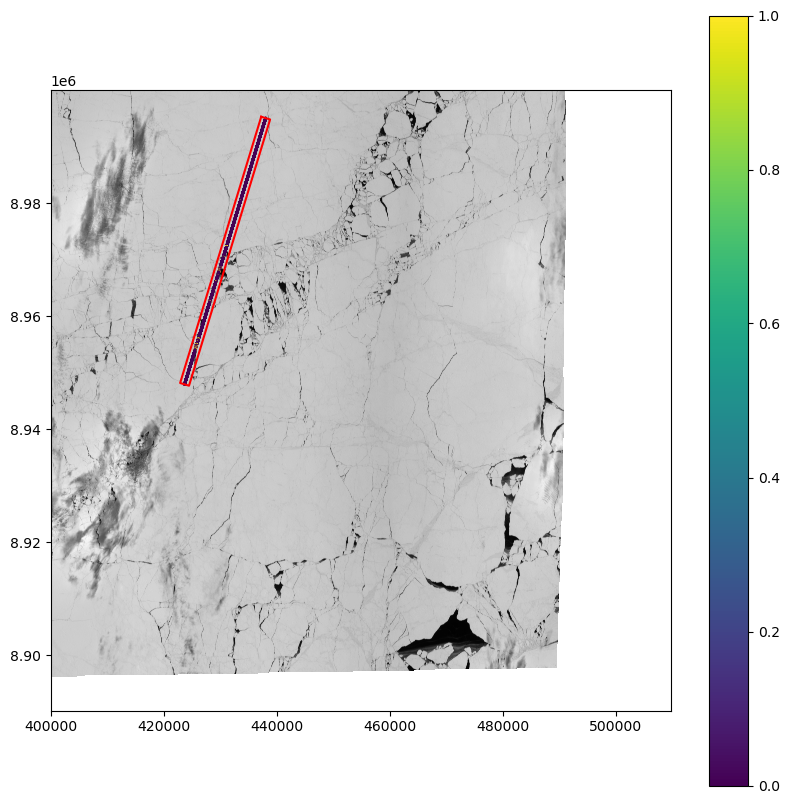

In [40]:
### Make new plot of Sentinel-2 image with ICESat-2 beam overlaid (AOI only)

# ICESat-2 parameter to plot
IS2_param = 'ssh_flag'

#subplot_kw = dict(projection=geoTIFF_proj)
fig, ax = plt.subplots(figsize=(10, 10))
# Plot image as grayscale
im = ax.imshow(surfReflectance, extent=geoTIFF_extent, origin='upper', cmap='gray')

# Overlay ICESat-2 data
plt.scatter(ATL07dF_crop_aoi['UTM_X'], ATL07dF_crop_aoi['UTM_Y'], s=1, c=ATL07dF_crop_aoi[IS2_param], cmap='viridis')
plt.plot([UL_x, LL_x, LR_x, UR_x, UL_x], [UL_y, LL_y, LR_y, UR_y, UL_y], c='r')
plt.colorbar()
plt.savefig(figPath+'s2-extra/overlay'+date+beam_name+relStr+str(Slim)+str(Nlim)+example+'.png', dpi=300)


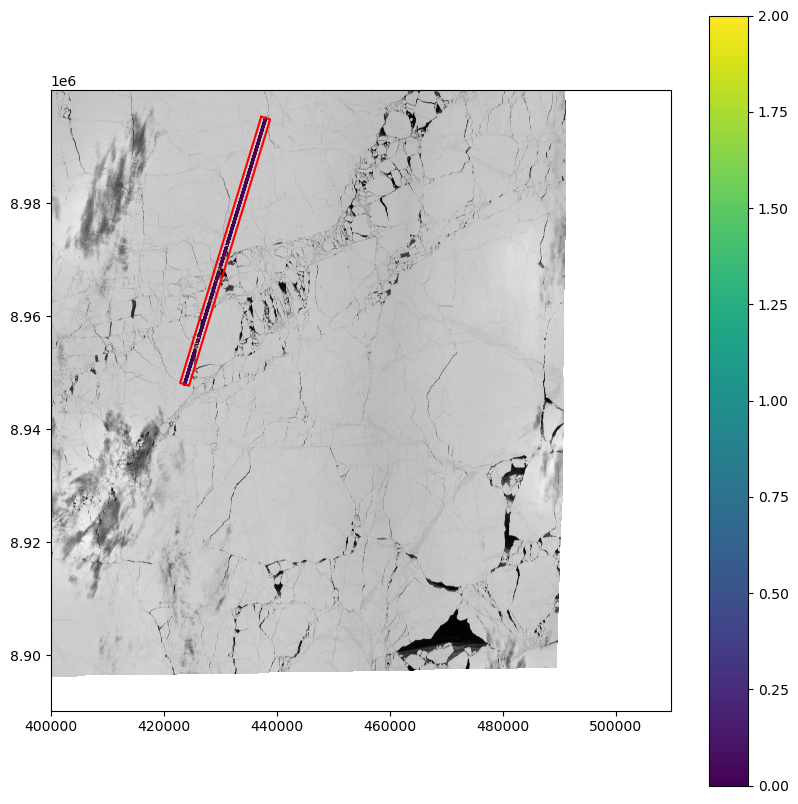

In [41]:
### Make new plot of Sentinel-2 image with ICESat-2 beam overlaid (AOI only)

# ICESat-2 parameter to plot
IS2_param = 'ssh_flag'

#subplot_kw = dict(projection=geoTIFF_proj)
fig, ax = plt.subplots(figsize=(10, 10))
# Plot image as grayscale
im = ax.imshow(surfReflectance, extent=geoTIFF_extent, origin='upper', cmap='gray')

# Overlay ICESat-2 data
plt.scatter(ATL10dF_crop_aoi['UTM_X'], ATL10dF_crop_aoi['UTM_Y'], s=1, c=ATL10dF_crop_aoi[IS2_param], cmap='viridis')
plt.plot([UL_x, LL_x, LR_x, UR_x, UL_x], [UL_y, LL_y, LR_y, UR_y, UL_y], c='r')
plt.colorbar()
plt.savefig(figPath+'s2-extra/overlay'+date+beam_name+relStr+str(Slim)+str(Nlim)+example+'atl10.png', dpi=300)


In [42]:
### Create shapefile with extent of AOI to be used for image cropping
# Call function to create AOI polygon shapefile
createShapefile(figPath+'s2-extra/AOIPolygon.shp', LL_x, LL_y, UL_x, UL_y, UR_x, UR_y, LR_x, LR_y)
shapefile=figPath+'AOIPolygon.shp'
outpath=figPath+'AOI.tif'

### Use GDAL to crop Sentinel-2 image to AOI

ds = gdal.Warp(figPath+'s2-extra/AOI.tif',
               imageFile,
               format='GTiff',
               cutlineDSName= figPath+'s2-extra/AOIPolygon.shp',
               cropToCutline = True,
               dstAlpha = True)
ds = None

### Convert GEOTiff AOI file to JPG for subsequent use

# Options to convert GEOTiff image to JPEG
options_list = ['-ot Byte','-of JPEG','-b 1','-scale'] 
options_string = " ".join(options_list)

# Use gdal_translate in Python
gdal.Translate(figPath+'s2-extra/AOI.jpg',
               figPath+'s2-extra/AOI.tif',
               options=options_string)

# Read new JPEG image
#image = cv2.imread('AOI.tif')
image = plt.imread(figPath+'s2-extra/AOI.jpg')

Warning 1: the source raster dataset has a SRS, but the cutline features
not.  We assume that the cutline coordinates are expressed in the destination SRS.
If not, cutline results may be incorrect.


In [43]:

# Rotate image by inclination angle according to satellite pass
# Descending
if rev is True:
    rot_im = ndimage.rotate(image, 180-inclin_deg, reshape=True, order=1)
# Ascending
if rev is False:
    rot_im = ndimage.rotate(image, inclin_deg, reshape=True, order=1)

### Trim edges to remove image padding
padNum=12
crop = np.delete(rot_im,np.where(~rot_im.any(axis=0))[0], axis=1)
crop = np.delete(crop,np.where(~crop.any(axis=1))[0], axis=0)
crop = np.delete(crop, range(padNum), 0)
crop = np.delete(crop, range(crop.shape[0]-padNum,crop.shape[0]), 0)
crop = np.delete(crop, range(padNum), 1)
crop = np.delete(crop, range(crop.shape[1]-padNum,crop.shape[1]), 1)

# Need to add a bigger loop to just load this if already generated the above!
#crop.dump(figPath+'s2-extra/cropped_image'+date+beam_name+relStr+str(Slim)+str(Nlim)+example)
np.savetxt(figPath+'s2-extra/cropped_image'+date+beam_name+relStr+str(Slim)+str(Nlim)+example+'.txt', crop)
print(crop.shape)

(159, 4924)


In [44]:
### Prepare data for plotting
# Filp image if necessary
if rev is False:
    crop = np.flipud(np.fliplr(crop))

start_index = ATL07dF_crop_aoi['along_dist'].iloc[0]
# Convert distances from meters to kilometers with respect to first segment in AOI
ATL07dF_crop_aoi['along_dist'] = ATL07dF_crop_aoi['along_dist'] - start_index
#ATL07dF_crop_aoi['along_dist'] = ATL07dF_crop_aoi['along_dist'].multiply(0.001)

# Convert distances from meters to kilometers with respect to first segment in AOI
ATL10dF_crop_aoi['along_dist'] = ATL10dF_crop_aoi['along_dist'] - start_index
#ATL10dF_crop_aoi['along_dist'] = ATL10dF_crop_aoi['along_dist'].multiply(0.001)

In [45]:
# Generate and print some stats about this subset
atl07_segs=np.size(ATL07dF_crop_aoi['ssh_flag'].values)
atl07_segs

ssh07_segs=np.size(np.where(ATL07dF_crop_aoi['ssh_flag'] == 1))
ssh07_segs

specular_segs=np.size(np.where((ATL07dF_crop_aoi['seg_type'] > 1.5)&(ATL07dF_crop_aoi['seg_type'] < 5.5)))
specular_segs

darklead_segs=np.size(np.where(ATL07dF_crop_aoi['seg_type'] > 5.5))
darklead_segs

cloud_segs=np.size(np.where(ATL07dF_crop_aoi['seg_type'] < 0.5))
cloud_segs

atl10_segs=np.size(ATL10dF_crop_aoi['ssh_flag'].values)
atl10_segs

ssh10_segs=np.size(np.where(ATL10dF_crop_aoi['ssh_flag'] > 1.5))
ssh10_segs

mean_fb=np.round(np.mean(ATL10dF_crop_aoi['freeboard']), decimals=3)
mean_fb

mafreeboards=ma.masked_where(ATL10dF_crop_aoi['freeboard']<0.06, ATL10dF_crop_aoi['freeboard'])

# Find the segments that are in ATL07 but not ATL10 
atlmask = np.isin(ATL07dF_crop_aoi['height_id'].values, ATL10dF_crop_aoi['height_segment_id'].values,  invert=True)
atlmaskint=atlmask.astype(int)
np.size(atlmask), np.size(np.nonzero(atlmaskint)[0])

#ssh ids in ATL10
ssh_ids=ATL07dF_crop_aoi['height_id'].values[np.where(ATL07dF_crop_aoi['ssh_flag'].values>0.5)]
ssh_inatl10 = np.isin(ssh_ids, ATL10dF_crop_aoi['height_segment_id'].values)

#ssh ids
radio_ids=ATL07dF_crop_aoi['height_id'].values[np.where(ATL07dF_crop_aoi['seg_type'].values<1.5)]
radio_inatl10 = np.isin(radio_ids, ATL10dF_crop_aoi['height_segment_id'].values,  invert=True)
radio_inatl10

percent=np.round(np.size(np.where(ATL07dF_crop_aoi['quality_flag']==5))/np.size(ATL07dF_crop_aoi['quality_flag'])*100, decimals=2)
percent

0.79

/tmp/ipykernel_1043/2676950984.py:68: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gnuplot', 7)    # 11 discrete colors


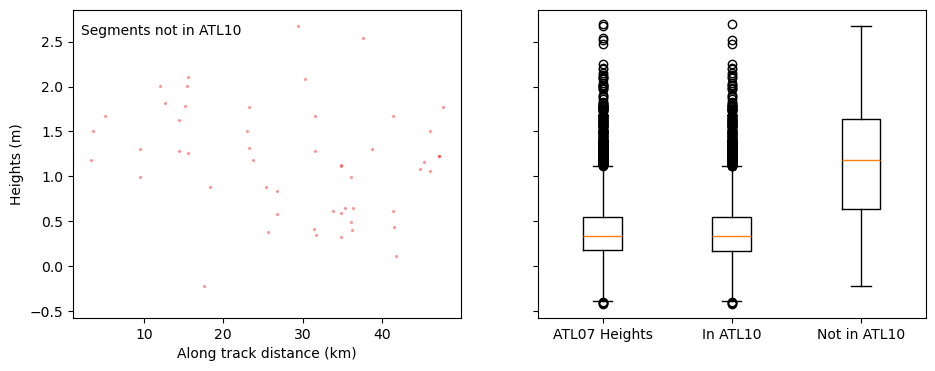

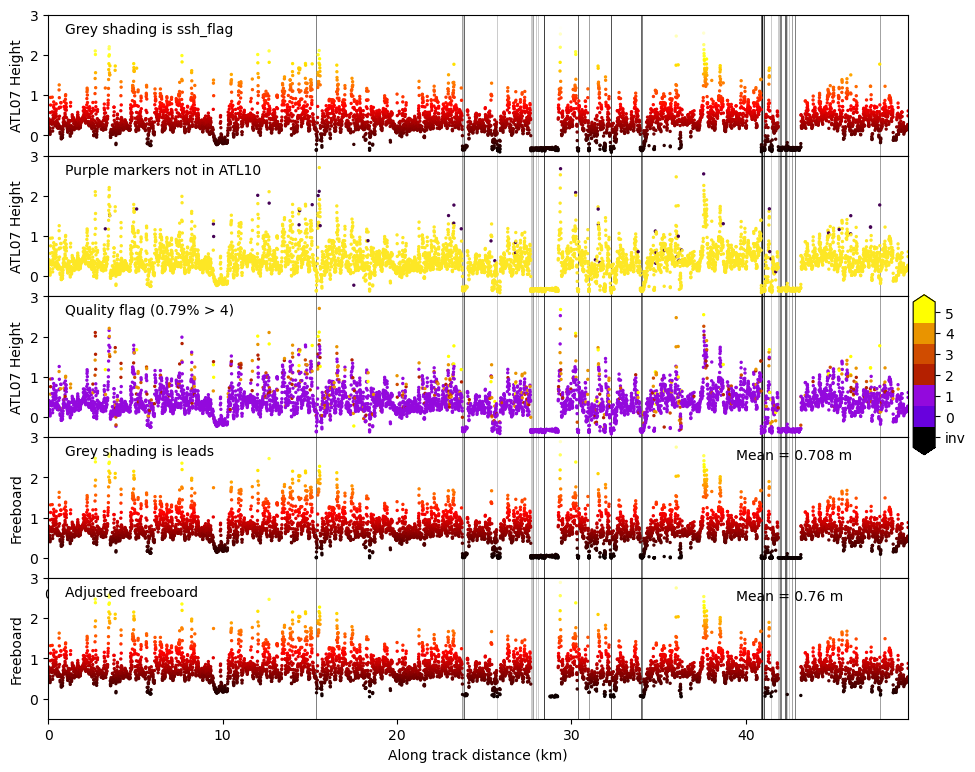

In [46]:
# Plot ATL07 diagnostic boxplot
plot_diagnostic_boxplot(ATL07dF_crop_aoi)

# Plot the height/freeboard data
plot_height_freeboard(ATL07dF_crop_aoi, ATL10dF_crop_aoi)

plotting final profile...


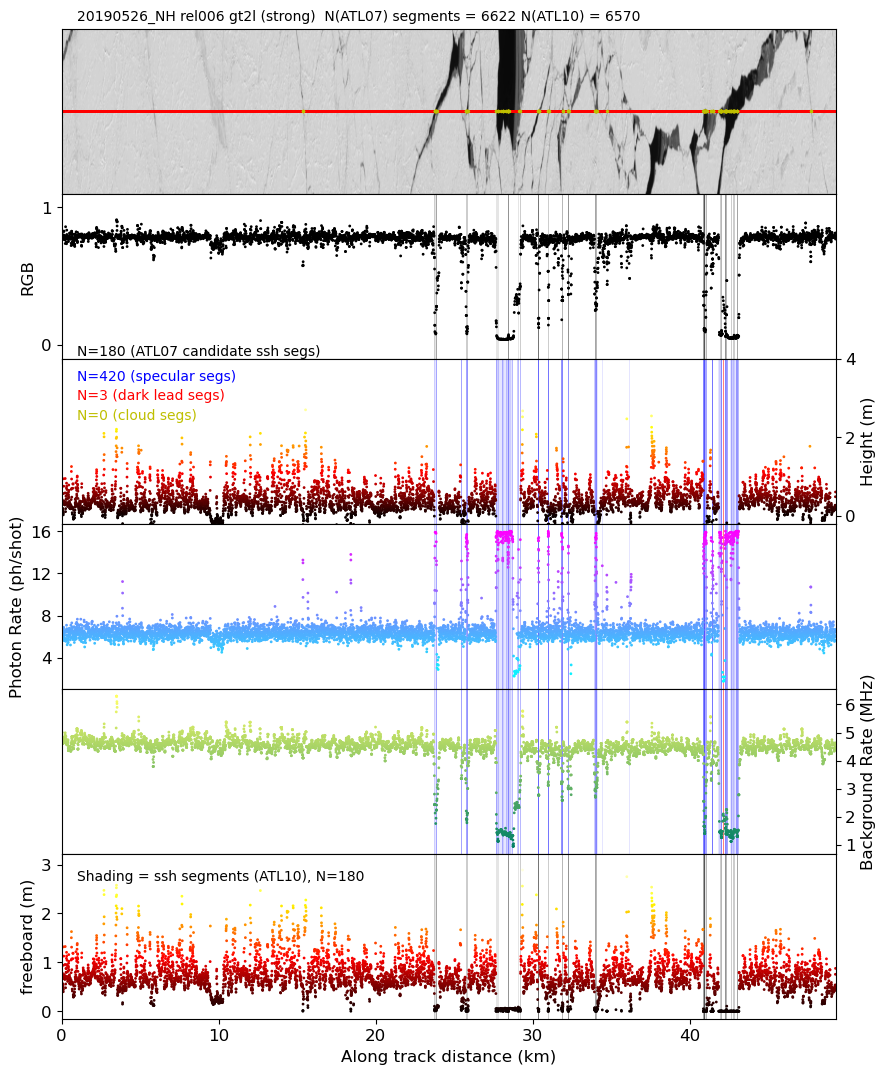

In [47]:
print('plotting final profile...')
shadingSize=30

#=========== Subplot 1 ===========
fig= plt.figure(figsize=(9,11))
fig.patch.set_facecolor('xkcd:white')

ax1 = plt.subplot2grid((12, 1), (0, 0), rowspan=2)
plt.imshow(crop, extent=[ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1], -buffer/1000, +buffer/1000], aspect='auto', cmap='gray', vmin=0, vmax=255)
plt.scatter(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']<0.5],np.zeros(len(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']<0.5])), c='r', s=buffer/800)
plt.scatter(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']>0.5],np.zeros(len(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']>0.5])), c='y', s=buffer/400, zorder=2)

#plt.scatter(ATL07dF_crop_aoi['along_dist'],np.zeros(len(ATL07dF_crop_aoi['along_dist'])), c=ATL07dF_crop_aoi['ssh_flag''], s=buffer/10000, cmap=cmap_ssh)
plt.autoscale(enable=True, axis='x', tight=True)
ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
#plt.xlim(ax6.get_xlim())
#plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])
plt.autoscale(enable=True, axis='x', tight=True)
#plt.suptitle(date, color='k', fontsize=12)
ax1.annotate(date+' '+relStr+' '+beam_name+' ('+beamStrength+')  N(ATL07) segments = '+str(atl07_segs)+' N(ATL10) = '+str(atl10_segs),xy=(0.02, 1.05), xycoords='axes fraction')

#=========== Subplot 2 ===========
ax2 = plt.subplot2grid((12, 1), (2, 0), rowspan=2)

for index, row in ATL07dF_crop_aoi.iterrows():
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    if (row['ssh_flag'] > 0.1):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)

plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['BandValue'], c=ATL07dF_crop_aoi['BandValue'], s=1, cmap='gray', vmin = 0, vmax = 255, zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax2.xaxis.set_ticklabels([])
if band=='RGB':
  ax2.set_yticks([0, 1])
  plt.ylim(-0.1,1.1)
  plt.ylabel('RGB', color='k', fontsize=12)
else:
  ax2.set_yticks([0, 255])
  plt.ylim(-1,266)
  plt.ylabel('Red band', color='k', fontsize=12)

ax2.tick_params(axis='y', colors='k', labelsize=12)
#plt.xlim(ax6.get_xlim())
#plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])

ax2.annotate('N='+str(ssh07_segs)+' (ATL07 candidate ssh segs)',xy=(0.02, 0.02), xycoords='axes fraction')

#=========== Subplot 3 ===========
ax3 = plt.subplot2grid((12, 1), (4, 0), rowspan=2)

for index, row in ATL07dF_crop_aoi.iterrows():
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    # cloud
    if row['seg_type'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.5)
    # Specular lead
    elif ((row['seg_type'] > 1.5) & (row['seg_type'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    # Dark lead
    elif row['seg_type'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.5)
            
plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['height'], c=ATL07dF_crop_aoi['height'], s=1, vmin=0, vmax=3, cmap='hot', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
plt.ylabel('Height (m)', color='k', fontsize=12)
ax3.tick_params(axis='y', colors='k', labelsize=12)
plt.ylim(-0.2,4)
#plt.xlim(ax5.get_xlim())
#plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])
#plt.xlim(ax6.get_xlim())

ax3.annotate('N='+str(specular_segs)+' (specular segs)',xy=(0.02, 0.87), color='b', xycoords='axes fraction')
ax3.annotate('N='+str(darklead_segs)+' (dark lead segs)',xy=(0.02, 0.75), color='r', xycoords='axes fraction')
ax3.annotate('N='+str(cloud_segs)+' (cloud segs)',xy=(0.02, 0.63), color='y', xycoords='axes fraction')

#=========== Subplot 4 ===========
ax4 = plt.subplot2grid((12, 1), (6, 0), rowspan=2)

for index, row in ATL07dF_crop_aoi.iterrows():
    #x0 = row['along_dist'] - row['seg_length']/2000
    #x1 = row['along_dist'] + row['seg_length']/2000
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    # cloud
    if row['seg_type'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.5)
    # specular lead
    elif ((row['seg_type'] > 1.5) & (row['seg_type'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['seg_type'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.5)
            
plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['photon_rate'], c=ATL07dF_crop_aoi['photon_rate'], s=1, cmap='cool', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax4.xaxis.set_ticklabels([])

plt.ylabel('Photon Rate (ph/shot)', color='k', fontsize=12)
#plt.xlim(ax5.get_xlim())
#plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])
#plt.xlim(ax6.get_xlim())

ax4.tick_params(axis='y', colors='k', labelsize=12)
ax4.yaxis.set_major_locator(MaxNLocator(5))

#=========== Subplot 5 ===========
ax5 = plt.subplot2grid((12, 1), (8, 0), rowspan=2)

for index, row in ATL07dF_crop_aoi.iterrows():
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    # cloud
    if row['seg_type'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.5)
    # specular lead
    elif ((row['seg_type'] > 1.5) & (row['seg_type'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['seg_type'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.5)
            
plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['bground_rate'], c=ATL07dF_crop_aoi['bground_rate'], s=1, cmap='summer', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax5.xaxis.set_ticklabels([])
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
plt.ylabel('Background Rate (MHz)', color='k', fontsize=12)
plt.xlabel('Along track distance (km)', color='k', fontsize=16)
ax5.tick_params(axis='y', colors='k', labelsize=12)
ax5.tick_params(axis='x', colors='k', labelsize=12)
ax5.yaxis.set_major_locator(MaxNLocator(integer=True))
#plt.xlim(ax6.get_xlim())

#=========== Subplot 7 ===========
ax6 = plt.subplot2grid((12, 1), (10, 0), rowspan=2)
for index, row in ATL10dF_crop_aoi.iterrows():
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    if (row['ssh_flag'] > 0.1):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)
        
plt.scatter(ATL10dF_crop_aoi['along_dist'],ATL10dF_crop_aoi['freeboard'], c=ATL10dF_crop_aoi['freeboard'], vmin=0, vmax=3, s=1, cmap='hot', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('freeboard (m)', color='k', fontsize=12)
ax6.yaxis.set_label_position("left")
ax6.yaxis.tick_left()
plt.xlabel('Along track distance (km)', color='k', fontsize=12)
ax6.tick_params(axis='y', colors='k', labelsize=12)
ax6.tick_params(axis='x', colors='k', labelsize=12)
ax6.annotate('Shading = ssh segments (ATL10), N='+str(ssh10_segs),xy=(0.02, 0.84), xycoords='axes fraction')


plt.subplots_adjust(left=0.08, right=0.94, top=0.96, bottom=0.06, wspace=0, hspace=0)
### Save plot to file
plt.savefig(figPath+'/S-2_overlay_'+date+beam_name+relStr+str(Slim)+str(Nlim)+example+'.png', dpi=300)


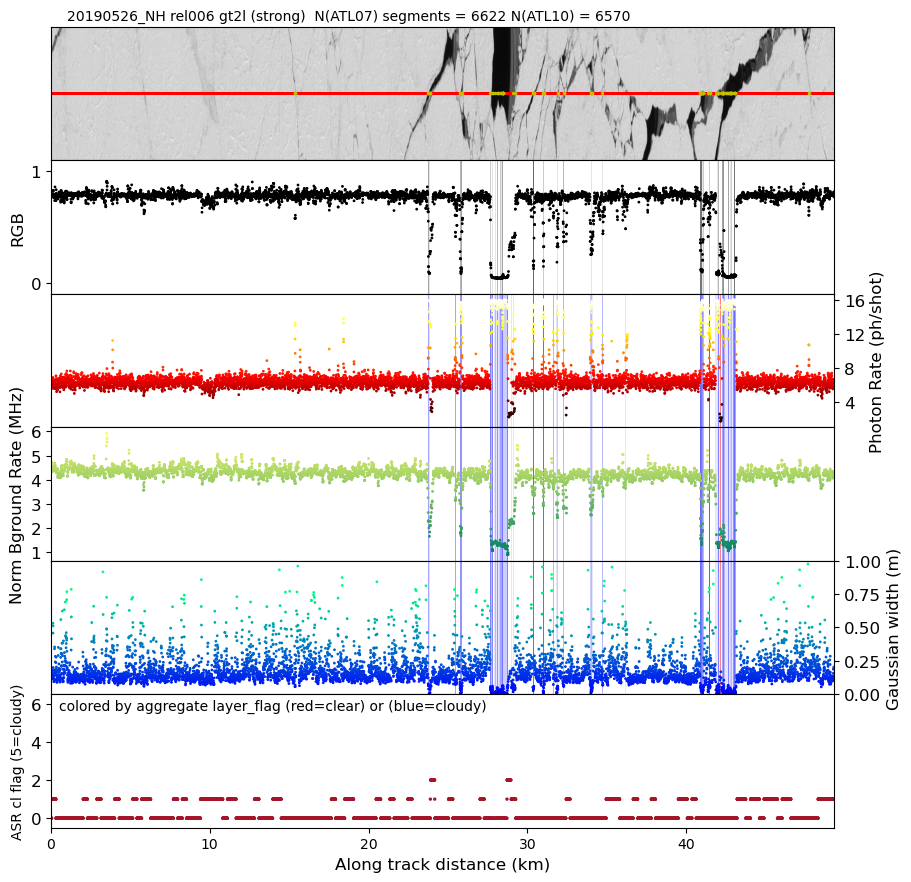

In [48]:
#=========== Subplot 1 ===========
fig= plt.figure(figsize=(9,9))
fig.patch.set_facecolor('xkcd:white')

ax1 = plt.subplot2grid((12, 1), (0, 0), rowspan=2)
plt.imshow(crop, extent=[ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1], -buffer/1000, +buffer/1000], aspect='auto', cmap='gray', vmin=0, vmax=255)
plt.scatter(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']<0.5],np.zeros(len(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']<0.5])), c='r', s=buffer/800)
plt.scatter(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']>0.5],np.zeros(len(ATL07dF_crop_aoi['along_dist'][ATL07dF_crop_aoi['ssh_flag']>0.5])), c='y', s=buffer/400, zorder=2)

#plt.scatter(ATL07dF_crop_aoi['along_dist'],np.zeros(len(ATL07dF_crop_aoi['along_dist'])), c=ATL07dF_crop_aoi['ssh_flag''], s=buffer/10000, cmap=cmap_ssh)

ax1.xaxis.set_ticklabels([])
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])
plt.autoscale(enable=True, axis='x', tight=True)
#plt.suptitle(date, color='k', fontsize=12)
ax1.annotate(date+' '+relStr+' '+beam_name+' ('+beamStrength+')  N(ATL07) segments = '+str(atl07_segs)+' N(ATL10) = '+str(atl10_segs),xy=(0.02, 1.05), xycoords='axes fraction')

#=========== Subplot 2 ===========
ax2 = plt.subplot2grid((12, 1), (2, 0), rowspan=2)

for index, row in ATL07dF_crop_aoi.iterrows():
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    if (row['ssh_flag'] > 0.1):
        plt.axvspan(x0,x1, facecolor='k', alpha=0.1)

plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['BandValue'], c=ATL07dF_crop_aoi['BandValue'], s=1, cmap='gray', vmin = 0, vmax = 255, zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax2.xaxis.set_ticklabels([])
if band=='RGB':
  ax2.set_yticks([0, 1])
  plt.ylim(-0.1,1.1)
  plt.ylabel('RGB', color='k', fontsize=12)
else:
  ax2.set_yticks([0, 255])
  plt.ylim(-1,266)
  plt.ylabel('Red band', color='k', fontsize=12)

ax2.tick_params(axis='y', colors='k', labelsize=12)
#plt.xlim(ax5.get_xlim())
plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])

#=========== Subplot 3 ===========
ax3 = plt.subplot2grid((12, 1), (4, 0), rowspan=2)


for index, row in ATL07dF_crop_aoi.iterrows():
    #x0 = row['along_dist'] - row['seg_length']/2000
    #x1 = row['along_dist'] + row['seg_length']/2000
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    # cloud
    if row['seg_type'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.5)
    # specular lead
    elif ((row['seg_type'] > 1.5) & (row['seg_type'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['seg_type'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.5)
            
plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['photon_rate'], c=ATL07dF_crop_aoi['photon_rate'], s=1, cmap='hot', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax3.xaxis.set_ticklabels([])

plt.ylabel('Photon Rate (ph/shot)', color='k', fontsize=12)
#plt.xlim(ax5.get_xlim())
plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()
ax3.tick_params(axis='y', colors='k', labelsize=12)
ax3.yaxis.set_major_locator(MaxNLocator(5))

#=========== Subplot 4 ===========
ax4 = plt.subplot2grid((12, 1), (6, 0), rowspan=2)

for index, row in ATL07dF_crop_aoi.iterrows():
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    # cloud
    if row['seg_type'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.5)
    # specular lead
    elif ((row['seg_type'] > 1.5) & (row['seg_type'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    elif row['seg_type'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.5)
            
plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['bground_rate_norm'], c=ATL07dF_crop_aoi['bground_rate_norm'], s=1, cmap='summer', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
ax4.xaxis.set_ticklabels([])

plt.ylabel('Norm Bground Rate (MHz)', color='k', fontsize=12)
#
ax4.tick_params(axis='y', colors='k', labelsize=12)
ax4.tick_params(axis='x', colors='k', labelsize=12)
ax4.yaxis.set_major_locator(MaxNLocator(integer=True))

#=========== Subplot 5 ===========
ax5 = plt.subplot2grid((12, 1), (8, 0), rowspan=2)

for index, row in ATL07dF_crop_aoi.iterrows():
    x0 = row['along_dist'] - shadingSize/2000
    x1 = row['along_dist'] + shadingSize/2000
    
    # cloud
    if row['seg_type'] < 0.5:
        plt.axvspan(x0,x1, facecolor='y', alpha=0.5)
    # Specular lead
    elif ((row['seg_type'] > 1.5) & (row['seg_type'] < 5.5)):
        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    # Dark lead
    elif row['seg_type'] > 5.5:
        plt.axvspan(x0,x1, facecolor='r', alpha=0.5)

width_max = np.nanpercentile(ATL07dF_crop_aoi['height_width'].values, 99)
plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['height_width'], c=ATL07dF_crop_aoi['height_width'], s=1, vmin=0, vmax=width_max, cmap='winter', zorder=2)
#plt.autoscale(enable=True, axis='x', tight=True)
ax5.xaxis.set_ticklabels([])
#ax6.yaxis.set_label_position("left")
#ax6.yaxis.tick_left()
plt.ylabel('Gaussian width (m)', color='k', fontsize=12)
plt.xlabel('Along track distance (km)', color='k', fontsize=12)
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.tick_params(axis='y', colors='k', labelsize=12)
plt.ylim(0,np.ceil(width_max))
#plt.xlim(ax5.get_xlim())
plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])

#=========== Subplot 5 ===========
ax6 = plt.subplot2grid((12, 1), (10, 0), rowspan=2)

plt.scatter(ATL07dF_crop_aoi['along_dist'],ATL07dF_crop_aoi['cloud_flag_asr'], c=ATL07dF_crop_aoi['layer_flag'], s=2, vmin=-0.1, vmax=1.1, cmap='RdBu', zorder=2)
plt.autoscale(enable=True, axis='x', tight=True)
#ax6.xaxis.set_ticklabels([])
#ax6.yaxis.set_label_position("left")
#ax6.yaxis.tick_left()
plt.ylabel('ASR cl flag (5=cloudy)', color='k', fontsize=10)
ax6.tick_params(axis='y', colors='k', labelsize=12)
ax6.yaxis.set_label_position("left")
ax6.yaxis.tick_left()
plt.ylim(-0.5,6.5)
#plt.xlim(ax5.get_xlim())
plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])
#plt.xlabel('Along track distance (km)', color='k', fontsize=12)
#ax7.xaxis.set_ticklabels([])
ax6.annotate(r'colored by aggregate layer_flag (red=clear) or (blue=cloudy)',xy=(0.01, 0.88), color='k',xycoords='axes fraction')
#ax6.xaxis.set_ticklabels([])

plt.xlabel('Along track distance (km)', color='k', fontsize=12)
#ax7.xaxis.set_ticklabels([])



plt.subplots_adjust(left=0.06, right=0.93, top=0.96, bottom=0.07, wspace=0, hspace=0)
### Save plot to file
plt.savefig(figPath+'/S-2_overlay_'+date+beam_name+relStr+str(Slim)+str(Nlim)+example+'radiometry.png', dpi=300)


In [49]:



#=========== Subplot 6 ===========
#ax6 = plt.subplot2grid((14, 1), (10, 0), rowspan=2)

#for index, row in ATL07dF_crop_aoi.iterrows():
#    x0 = row['along_dist'] - shadingSize/2000
#    x1 = row['along_dist'] + shadingSize/2000
    
    # cloud
#    if row['seg_type'] < 0.5:
#        plt.axvspan(x0,x1, facecolor='y', alpha=0.5)
    # Specular lead
#    elif ((row['seg_type'] > 1.5) & (row['seg_type'] < 5.5)):
#        plt.axvspan(x0,x1, facecolor='b', alpha=0.1)
    # Dark lead
#    elif row['seg_type'] > 5.5:
#        plt.axvspan(x0,x1, facecolor='r', alpha=0.5)
            
#plt.scatter(ATL07dF_crop_aoi['along_dist'],100.*(ATL07dF_crop_aoi['segs_used']/ATL07dF_crop_aoi['segs_total']), c=100.*(ATL07dF_crop_aoi['segs_used']/ATL07dF_crop_aoi['segs_total']), s=1, vmin=0, vmax=100, cmap='spring', zorder=2)
#plt.autoscale(enable=True, axis='x', tight=True)
#ax6.xaxis.set_ticklabels([])
#ax6.yaxis.set_label_position("left")
#ax6.yaxis.tick_left()
#plt.ylabel('Pulses used (%)', color='k', fontsize=12)
#ax6.tick_params(axis='y', colors='k', labelsize=12)
#plt.ylim(-10,4)
#plt.xlim(ax5.get_xlim())
#plt.xlim([ATL07dF_crop_aoi.along_dist.iloc[0], ATL07dF_crop_aoi.along_dist.iloc[-1]])